# Transferência de aprendizado e ajuste fino

<br>

Neste tutorial, você aprenderá a classificar imagens de cães e gatos usando o aprendizado de transferência de uma rede pré-treinada.

Um modelo pré-treinado é uma rede salva que foi previamente treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagem em grande escala. Você usa o modelo pré-treinado como está ou usa o aprendizado de transferência para personalizar esse modelo para uma determinada tarefa.

A intuição por trás do aprendizado de transferência para classificação de imagens é que, se um modelo for treinado em um conjunto de dados grande e geral o suficiente, esse modelo servirá efetivamente como um modelo genérico do mundo visual. Você pode aproveitar esses mapas de recursos aprendidos sem precisar começar do zero treinando um modelo grande em um grande conjunto de dados.

Neste notebook, você tentará duas maneiras de personalizar um modelo pré-treinado:

- Extração de recursos: use as representações aprendidas por uma rede anterior para extrair recursos significativos de novas amostras. Você simplesmente adiciona um novo classificador, que será treinado do zero, em cima do modelo pré-treinado para que você possa redirecionar os mapas de recursos aprendidos anteriormente para o conjunto de dados.

Você não precisa (re)treinar todo o modelo. A rede convolucional base já contém recursos que são genericamente úteis para classificar imagens. No entanto, a parte final de classificação do modelo pré-treinado é específica para a tarefa de classificação original e, posteriormente, específica para o conjunto de classes em que o modelo foi treinado.

- Ajuste fino: Descongele algumas das camadas superiores de uma base de modelo congelada e treine em conjunto as camadas do classificador recém-adicionadas e as últimas camadas do modelo base. Isso nos permite "ajustar" as representações de recursos de ordem superior no modelo base para torná-las mais relevantes para a tarefa específica.

Você seguirá o fluxo de trabalho geral de aprendizado de máquina.

- Examinar e entender os dados
- Crie um pipeline de entrada, neste caso usando Keras ImageDataGenerator
- Componha o modelo
- Carregue no modelo base pré-treinado (e pesos pré-treinados)
- Empilhe as camadas de classificação no topo
- Treine o modelo
- Avaliar modelo

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

Neste tutorial, você usará um conjunto de dados contendo vários milhares de imagens de cães e gatos. Faça download e extraia um arquivo zip contendo as imagens e crie um tf.data.Dataset para treinamento e validação usando o utilitário tf.keras.utils.image_dataset_from_directory . Você pode aprender mais sobre como carregar imagens neste tutorial .

In [37]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [38]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

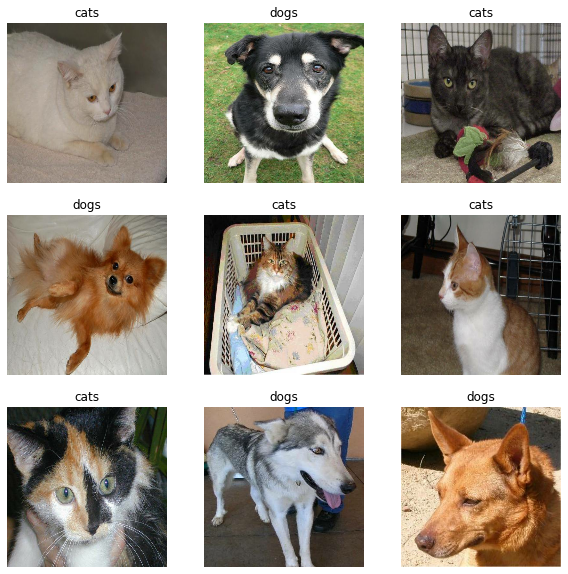

In [39]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como o conjunto de dados original não contém um conjunto de teste, você criará um. Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando tf.data.experimental.cardinality e mova 20% deles para um conjunto de teste.

In [40]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [41]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


<br>

Configurar o conjunto de dados para desempenho

Use a pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio. Para saber mais sobre esse método, consulte o guia de desempenho de dados .

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente a diversidade de amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e reduzir o overfitting . Você pode aprender mais sobre o aumento de dados neste tutorial .

In [43]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

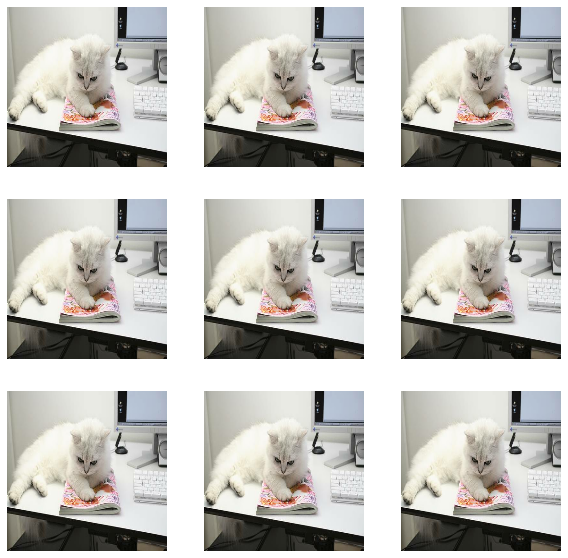

In [44]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

Em instantes, você fará o download do tf.keras.applications.MobileNetV2 para uso como modelo base. Este modelo espera valores de pixel em [-1, 1] , mas neste ponto, os valores de pixel em suas imagens estão em [0, 255] . Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [46]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

<br>

### Crie o modelo base a partir dos convnets pré-treinados
Você criará o modelo base a partir do modelo MobileNet V2 desenvolvido no Google. Isso é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes. ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, como jackfruit e syringe . Essa base de conhecimento nos ajudará a classificar cães e gatos de nosso conjunto de dados específico.

Primeiro, você precisa escolher qual camada do MobileNet V2 você usará para extração de recursos. A última camada de classificação (no "topo", pois a maioria dos diagramas de modelos de aprendizado de máquina vai de baixo para cima) não é muito útil. Em vez disso, você seguirá a prática comum de depender da última camada antes da operação de nivelamento. Essa camada é chamada de "camada de gargalo". Os recursos da camada de gargalo retêm mais generalidade em comparação com a camada final/superior.

Primeiro, instancie um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento include_top=False , você carrega uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para extração de recursos.

In [47]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                        weights='imagenet')                                               

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [48]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Extração de recursos
Nesta etapa, você congelará a base convolucional criada na etapa anterior e usará como extrator de recursos. Além disso, você adiciona um classificador em cima dele e treina o classificador de nível superior.

### Congele a base convolucional
É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

In [49]:
base_model.trainable = False

### Nota importante sobre camadas de BatchNormalization

Muitos modelos contêm camadas tf.keras.layers.BatchNormalization . Essa camada é um caso especial e precauções devem ser tomadas no contexto do ajuste fino, conforme mostrado mais adiante neste tutorial.

Quando você define layer.trainable = False , a camada BatchNormalization será executada no modo de inferência e não atualizará suas estatísticas de média e variação.

Quando você descongela um modelo que contém camadas BatchNormalization para fazer o ajuste fino, você deve manter as camadas BatchNormalization no modo de inferência passando training = False ao chamar o modelo base. Caso contrário, as atualizações aplicadas aos pesos não treináveis ​​destruirão o que o modelo aprendeu.

In [50]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

<br>

### Adicionar um cabeçalho de classificação
Para gerar previsões a partir do bloco de feições, calcule a média das localizações espaciais 5x5 , usando uma camada tf.keras.layers.GlobalAveragePooling2D para converter as feições em um único vetor de 1280 elementos por imagem.

In [51]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada tf.keras.layers.Dense para converter esses recursos em uma única previsão por imagem. Você não precisa de uma função de ativação aqui porque essa previsão será tratada como um logit ou um valor bruto de previsão. Números positivos predizem a classe 1, números negativos predizem a classe 0.

In [52]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Construa um modelo encadeando as camadas de aumento de dados, redimensionamento, base_model e extrator de recursos usando a API funcional do Keras . Como mencionado anteriormente, use training=False pois nosso modelo contém uma camada BatchNormalization 

In [53]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

<br>

### Compilar o modelo

Compile o modelo antes de treiná-lo. Como existem duas classes, use a perda tf.keras.losses.BinaryCrossentropy com from_logits=True , pois o modelo fornece uma saída linear.

In [54]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Os 2,5 milhões de parâmetros no MobileNet estão congelados, mas existem 1,2 mil parâmetros treináveis na camada Dense. Estes são divididos entre dois objetos tf.Variable , os pesos e os bias.

In [56]:
len(model.trainable_variables)

2

### Treine o modelo

In [57]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 9s 287ms/step - loss: 0.9057 - accuracy: 0.3874


In [58]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.39


In [59]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 30s 430ms/step - loss: 0.3671 - accuracy: 0.8190 - val_loss: 0.1228 - val_accuracy: 0.9653
Epoch 2/100
63/63 [==============================] - 26s 406ms/step - loss: 0.1873 - accuracy: 0.9170 - val_loss: 0.0856 - val_accuracy: 0.9752
Epoch 3/100
63/63 [==============================] - 26s 407ms/step - loss: 0.1725 - accuracy: 0.9210 - val_loss: 0.0725 - val_accuracy: 0.9790
Epoch 4/100
63/63 [==============================] - 26s 408ms/step - loss: 0.1274 - accuracy: 0.9470 - val_loss: 0.0649 - val_accuracy: 0.9814
Epoch 5/100
63/63 [==============================] - 26s 407ms/step - loss: 0.1329 - accuracy: 0.9460 - val_loss: 0.0607 - val_accuracy: 0.9839
Epoch 6/100
63/63 [==============================] - 26s 408ms/step - loss: 0.1389 - accuracy: 0.9395 - val_loss: 0.0731 - val_accuracy: 0.9703
Epoch 7/100
63/63 [==============================] - 26s 408ms/step - loss: 0.1367 - accuracy: 0.9440 - val_loss: 0.0605 - val_accuracy:

### Curvas de aprendizado

Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixo.

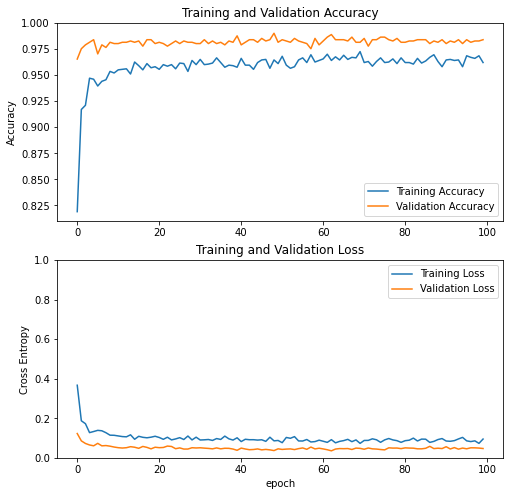

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

Em menor grau, também é porque as métricas de treinamento relatam a média de uma época, enquanto as métricas de validação são avaliadas após a época, portanto, as métricas de validação veem um modelo que foi treinado um pouco mais.

### Afinação
No experimento de extração de recursos, você estava treinando apenas algumas camadas em cima de um modelo base MobileNetV2. Os pesos da rede pré-treinada não foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado juntamente com o treinamento do classificador que você adicionou. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.

Além disso, você deve tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet. Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é. As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos os tipos de imagens. À medida que você sobe, os recursos são cada vez mais específicos para o conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar esses recursos especializados para trabalhar com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

Descongele as camadas superiores do modelo
Tudo o que você precisa fazer é descongelar o base_model e definir as camadas inferiores como não treináveis. Em seguida, você deve recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [61]:
base_model.trainable = True

In [62]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 95

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compilar o modelo

Como você está treinando um modelo muito maior e deseja readaptar os pesos pré-treinados, é importante usar uma taxa de aprendizado menor neste estágio. Caso contrário, seu modelo pode se ajustar muito rapidamente.

In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [65]:
len(model.trainable_variables)

62

### Continue treinando o modelo
Se você treinou para convergência anteriormente, esta etapa melhorará sua precisão em alguns pontos percentuais

In [66]:
fine_tune_epochs = 85
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/185
63/63 [==============================] - 41s 588ms/step - loss: 0.1492 - accuracy: 0.9485 - val_loss: 0.0505 - val_accuracy: 0.9765
Epoch 101/185
63/63 [==============================] - 36s 570ms/step - loss: 0.0816 - accuracy: 0.9685 - val_loss: 0.0407 - val_accuracy: 0.9876
Epoch 102/185
63/63 [==============================] - 36s 570ms/step - loss: 0.0616 - accuracy: 0.9745 - val_loss: 0.0441 - val_accuracy: 0.9827
Epoch 103/185
63/63 [==============================] - 36s 569ms/step - loss: 0.0729 - accuracy: 0.9695 - val_loss: 0.0462 - val_accuracy: 0.9777
Epoch 104/185
63/63 [==============================] - 36s 571ms/step - loss: 0.0609 - accuracy: 0.9750 - val_loss: 0.0454 - val_accuracy: 0.9864
Epoch 105/185
63/63 [==============================] - 36s 570ms/step - loss: 0.0661 - accuracy: 0.9730 - val_loss: 0.0431 - val_accuracy: 0.9814
Epoch 106/185
63/63 [==============================] - 36s 572ms/step - loss: 0.0477 - accuracy: 0.9805 - val_loss: 0.0521 -

Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao ajustar as últimas camadas do modelo base do MobileNetV2 e treinar o classificador em cima dele. A perda de validação é muito maior do que a perda de treinamento, então você pode ter algum overfitting.

Você também pode ter algum overfitting, pois o novo conjunto de treinamento é relativamente pequeno e semelhante aos conjuntos de dados originais do MobileNetV2.

Após o ajuste fino, o modelo atinge quase 98% de precisão no conjunto de validação

In [67]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

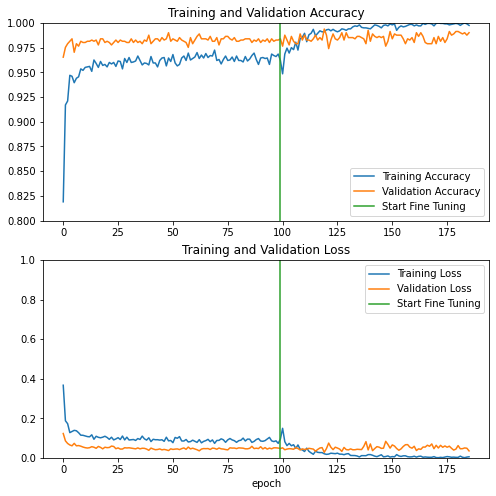

In [68]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Avaliação e previsão

Finalmente, você pode verificar o desempenho do modelo em novos dados usando o conjunto de teste.

In [69]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 288ms/step - loss: 0.0567 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0]
Labels:
 [0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0]


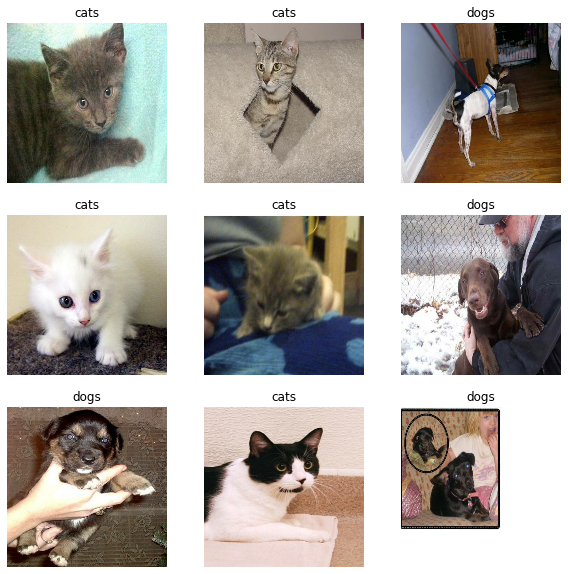

In [70]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Resumo
Usando um modelo pré-treinado para extração de recursos : ao trabalhar com um conjunto de dados pequeno, é uma prática comum aproveitar os recursos aprendidos por um modelo treinado em um conjunto de dados maior no mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador totalmente conectado no topo. O modelo pré-treinado é "congelado" e apenas os pesos do classificador são atualizados durante o treinamento. Nesse caso, a base convolucional extraiu todos os recursos associados a cada imagem e você acabou de treinar um classificador que determina a classe da imagem a partir desse conjunto de recursos extraídos.

Ajustando um modelo pré-treinado : para melhorar ainda mais o desempenho, pode-se querer redirecionar as camadas de nível superior dos modelos pré-treinados para o novo conjunto de dados por meio de ajuste fino. Nesse caso, você ajustou seus pesos para que seu modelo aprendesse recursos de alto nível específicos para o conjunto de dados. Essa técnica geralmente é recomendada quando o conjunto de dados de treinamento é grande e muito semelhante ao conjunto de dados original no qual o modelo pré-treinado foi treinado.